In [160]:
import pandas as pd
import numpy as np
from skimage import io
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as Qda
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [111]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [19]:
IMG_PATH = "data/yukon.tif"

In [95]:
data_lake = pd.read_csv("data_class/lake.csv", index_col="Index")
data_land = pd.read_csv("data_class/land.csv", index_col="Index")
data_water = pd.read_csv("data_class/water.csv", index_col="Index")
data_water = pd.concat([data_water, data_lake])

water_test = pd.read_csv("data_class/water_test.csv", index_col="Index")
land_test = pd.read_csv("data_class/land_test.csv", index_col="Index")

In [96]:
data_water["label"] = "water"
data_land["label"] = "land"

water_test["label"] = "water"
land_test["label"] = "land"

In [119]:
len(land_test)

2952

In [120]:
len(water_test)

1650

In [97]:
data = pd.concat([data_land, data_water])
data_test =pd.concat([water_test, land_test])

In [121]:
X_train = data.iloc[:, 0:6]
y_train = data.iloc[:, 6]
X_test = data_test.iloc[:, 0:6]
y_test = data_test.iloc[:, 6]

In [122]:
qda = Qda()

In [123]:
qda.fit(X=X_train, y=y_train)

QuadraticDiscriminantAnalysis()

In [124]:
y_pred = qda.predict(X_test)

In [126]:
cm = confusion_matrix(y_test, y_pred)

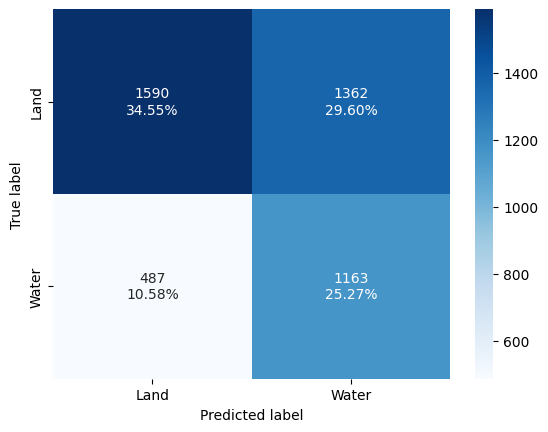

In [129]:
categories = ["Land", "Water"]
make_confusion_matrix(cm, categories=categories, sum_stats=False)

In [130]:
img = io.imread(IMG_PATH)

In [131]:
img.shape

(1294, 1734, 6)

In [132]:
w, h, ch = img.shape

In [133]:
img_reshaped = img.reshape(w * h, ch)

In [143]:
y_pred = qda.predict(img_reshaped)
y_pred_proba = qda.predict_proba(img_reshaped)

/Users/wojpon/.pyenv/versions/3.11.0/envs/mfaasi/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/Users/wojpon/.pyenv/versions/3.11.0/envs/mfaasi/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(


In [137]:
y_pred_proba_land = y_pred_proba[:, 0]
y_pred_proba_water = y_pred_proba[:, 1]

In [140]:
y_pred_proba_land = y_pred_proba_land.reshape(w, h)
y_pred_proba_water = y_pred_proba_water.reshape(w, h)

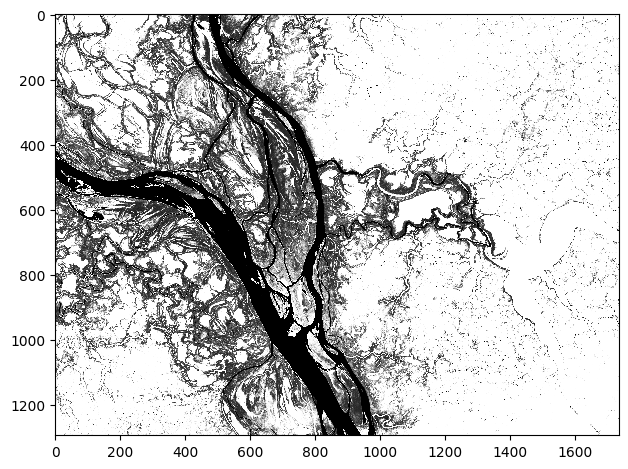

In [141]:
io.imshow(y_pred_proba_land)

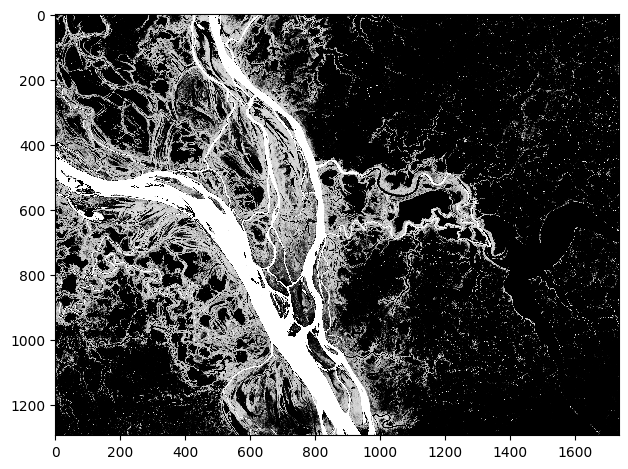

In [142]:
io.imshow(y_pred_proba_water)

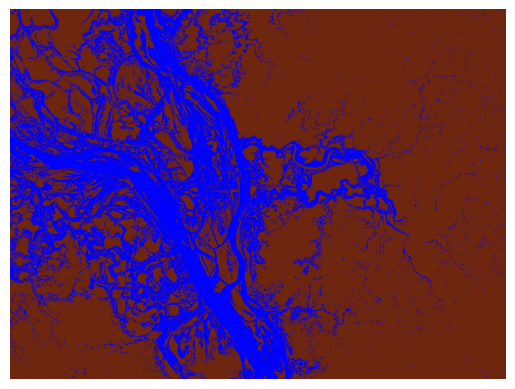

In [158]:
# Assuming you have a 2D array representing the land and water values
data = y_pred.reshape(w, h)

# Define colors for land and water
land_color = [110, 38, 14]  # Green
water_color = [0, 0, 255]  # Blue

# Create an empty RGB image
height, width = data.shape
rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a mask based on land and water values
land_mask = (data == "land")
water_mask = (data == "water")

# Assign colors to the corresponding pixels in the RGB image
rgb_image[land_mask] = land_color
rgb_image[water_mask] = water_color

# Display the result using matplotlib
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

### Random Forest

In [161]:
rfc = RandomForestClassifier()

In [162]:
rfc.fit(X=X_train, y=y_train)

RandomForestClassifier()

In [163]:
y_pred = rfc.predict(X_test)

In [164]:
cm = confusion_matrix(y_test, y_pred)

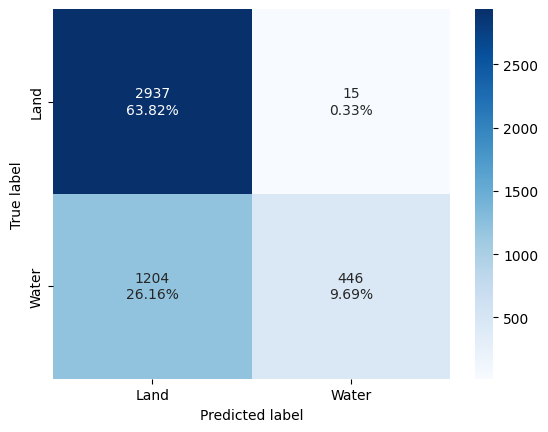

In [165]:
categories = ["Land", "Water"]
make_confusion_matrix(cm, categories=categories, sum_stats=False)

In [166]:
img = io.imread(IMG_PATH)

In [167]:
img.shape

(1294, 1734, 6)

In [168]:
w, h, ch = img.shape

In [169]:
img_reshaped = img.reshape(w * h, ch)

In [170]:
y_pred = rfc.predict(img_reshaped)
y_pred_proba = rfc.predict_proba(img_reshaped)

/Users/wojpon/.pyenv/versions/3.11.0/envs/mfaasi/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/wojpon/.pyenv/versions/3.11.0/envs/mfaasi/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [171]:
y_pred_proba_land = y_pred_proba[:, 0]
y_pred_proba_water = y_pred_proba[:, 1]

In [172]:
y_pred_proba_land = y_pred_proba_land.reshape(w, h)
y_pred_proba_water = y_pred_proba_water.reshape(w, h)

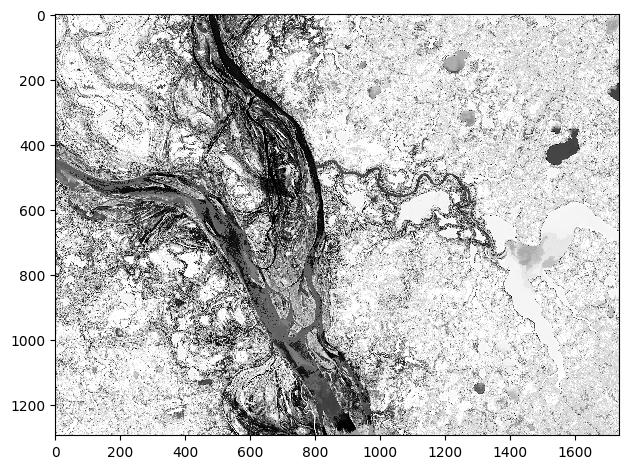

In [173]:
io.imshow(y_pred_proba_land)

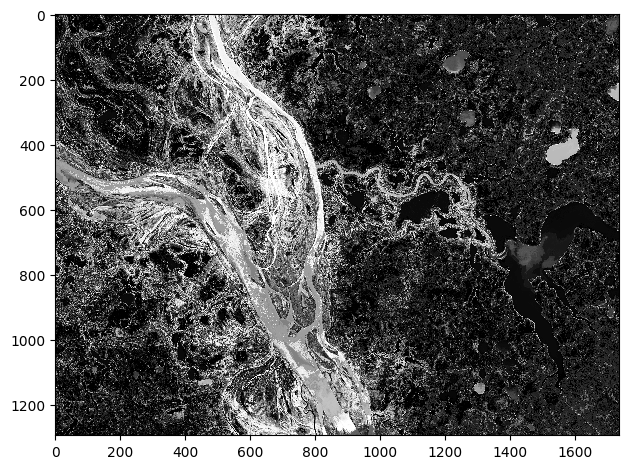

In [174]:
io.imshow(y_pred_proba_water)

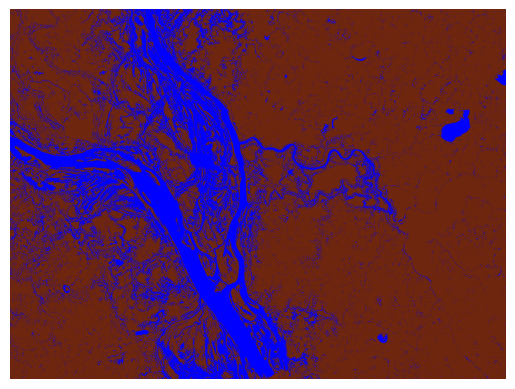

In [175]:
# Assuming you have a 2D array representing the land and water values
data = y_pred.reshape(w, h)

# Define colors for land and water
land_color = [110, 38, 14]  # Green
water_color = [0, 0, 255]  # Blue

# Create an empty RGB image
height, width = data.shape
rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a mask based on land and water values
land_mask = (data == "land")
water_mask = (data == "water")

# Assign colors to the corresponding pixels in the RGB image
rgb_image[land_mask] = land_color
rgb_image[water_mask] = water_color

# Display the result using matplotlib
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

### PCA

In [155]:
scaler = StandardScaler()
pca = PCA()